<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2023/blob/main/notebooks/es1/AML_2023_HandsOn_1_Classification_INTRO_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First, connect your drive!

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Go to the RiNNgs folder!
use the command "cd" to  change directory


```
cd "directory"
```


then use "ls" (list) to show the files in the folder

## Are you in the correct directory?


In [2]:
cd /content/gdrive/MyDrive/RiNNgs

/content/gdrive/MyDrive/RiNNgs


# What's in the directory you are in?



In [3]:
ls

ape62.py  apesettings.py  data_preprocess.py  __pycache__/  riNNgs.ipynb
apeml.py  data/           imager.py           results/


# Lets create all the folders needed

In [4]:
import os
def CreateDir(path):
	# Create a directory if it does not exist
	success = os.path.exists(path)
	if not success:
		os.makedirs(path)
CreateDir("results")#
CreateDir("results/display")
CreateDir("results/preprocess")

# We need to build the dataset.
How can we call a python code from a notebook script?

Use the command


```
! python script.py ARG1,ARG2,...,ARGN
```

to call the "data_preprocess.py" that will find the run 0811 and form 16x16 images from it.

arguments are "08011 Conv 16 np_reco 0"

**Ignore all the warnings and the tensorflow calls. This function is doing a lot more than what we need**

In [5]:
! python data_preprocess.py 08011 Conv 16 np_reco 0

2023-03-07 22:04:46.485487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 22:04:47.673115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-07 22:04:47.673219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-07 22:04:47.673238: W tensorfl

# Where are our files?

The script will write two files in the results/preprocess folder that we created before.

Check if you can find the files and that  *x_all_** is the rigth size (around 40 MB)

Use the command


```
ls -lh "path"
```



In [6]:
! ls -lh  results/preprocess/

total 40M
-rw------- 1 root root  87K Mar  7 22:04 prova16.pdf
-rw------- 1 root root  40M Mar  7 22:04 x_all_08011.npy
-rw------- 1 root root 313K Mar  7 22:04 y_all_08011.npy


# Read the data, check the data format, print an element.


*   Load the data with np.load
*   Print the data shape
*   Check the variable type
*   Use plt.matshow() to print an element



In [7]:
import numpy as np
dataset = "08011"
x_all = np.load( 'results/preprocess/' + 'x_all_{}.npy'.format(dataset))
y_all = np.load( 'results/preprocess/' + 'y_all_{}.npy'.format(dataset))


In [8]:
print("data shape : ", x_all.shape)
print("label shape : ", y_all.shape)
print("type of x_all[0]: ", type(x_all[0,0,0]))

data shape :  (20000, 16, 16)
label shape :  (20000, 4)
type of x_all[0]:  <class 'numpy.float64'>


Text(0.5, 1.0, 'An example of class 3')

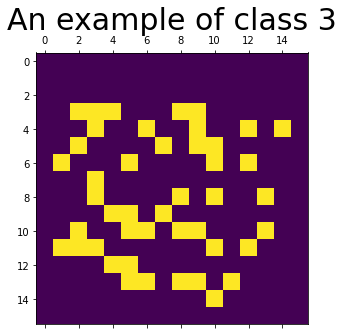

In [9]:
import matplotlib.pyplot as plt
to_plot = 1001
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.matshow(x_all[to_plot,:,:])
ax.set_title("An example of class {}".format(np.argmax(y_all[to_plot])),fontsize=30)

# Plot an histogram of the average intensity per class
# A  trick:
When you do this kind of data visualization, you are creating a lot of variables. If you wrap your code in a function you will keep the workspace clean.

this shoud be [N,1] :  (20000,)


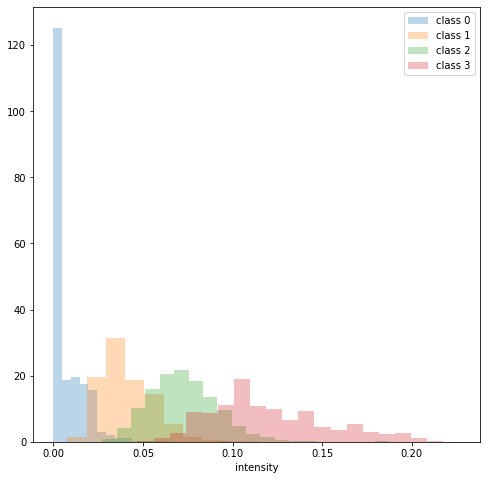

In [10]:
def plot_histo(x_all, y_all):

  classes = np.argmax(y_all,axis=1)

  intensities = x_all.reshape(x_all.shape[0],-1).mean(axis=1)
  print("this shoud be [N,1] : ",intensities.shape)


  f,ax = plt.subplots(1,1,figsize=(8,8))
  for c in [0,1,2,3]:
    ax.hist(intensities[classes==c],20,alpha=0.3,label="class {}".format(c),density=True)

  ax.set_xlabel("intensity")
  ax.legend()

plot_histo(x_all, y_all)

this shoud be [N,1] :  (18402,)


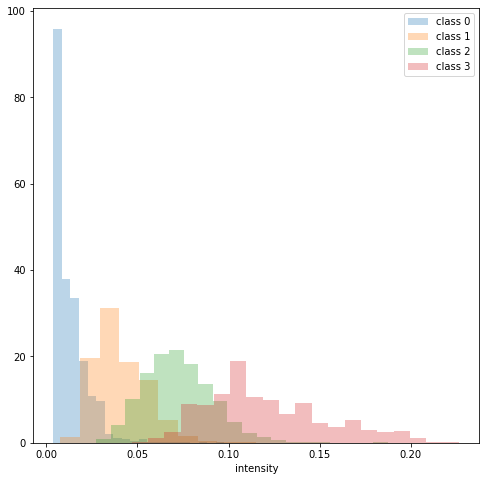

In [11]:
# remove the empty images
def remove_empty(x_all, y_all):
  intensities = x_all.reshape(x_all.shape[0],-1).mean(axis=1)
  y_all = y_all[intensities>0]
  x_all = x_all[intensities>0]
  return x_all, y_all

x_all, y_all = remove_empty(x_all, y_all)
plot_histo(x_all, y_all)

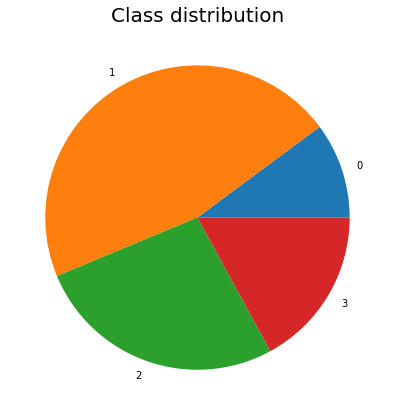

In [12]:

def piechartclasses(y_all):
  classes = np.argmax(y_all, axis=1)
  c = np.unique(classes)
  arr_c = [np.mean(classes==i) for i in c]


 
  # Creating plot
  fig = plt.figure(figsize =(10, 7))
  plt.pie(arr_c, labels = c)
 
  # show plot
  plt.title("Class distribution",fontsize=20)
  plt.show()
piechartclasses(y_all) 

# Load images and prepare batches

In [13]:
import torch.utils.data as data
class BalancedDataLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

        # If sampler is not provided, create a new one
    
        # Count the number of samples in each class
        class_counts = torch.bincount(torch.tensor(np.argmax(dataset.y,axis=1)))

        # Compute the weight of each sample
        weights = 1.0 / class_counts[np.argmax(dataset.y,axis=1)]

        # Create a sampler that samples each class with equal probability
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

        super().__init__(dataset, batch_size=batch_size, sampler=sampler)

In [14]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=42)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now you have X_train, y_train, X_val, y_val, X_test, and y_test as your splits




from torch.utils.data import Dataset, DataLoader
import torch

class HitImageGenerator(Dataset):
  

    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        tensor_image = torch.from_numpy(image).unsqueeze(0).float()  # Add a channel dimension
        tensor_label = torch.from_numpy(label).float()
        return tensor_image, tensor_label

# Lets split the dataset

train_dataset = HitImageGenerator(X_train,y_train)
train_loader = BalancedDataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = HitImageGenerator(X_val,y_val)
val_loader = BalancedDataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = HitImageGenerator(X_test,y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)# no balanced generator for the test

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 2)
        self.fc1 = nn.Linear(16 * 2 * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
def accuracy(y_pred, y_true):
    """
    Calculates the accuracy of the predicted labels.

    Args:
        y_pred (torch.Tensor): predicted labels
        y_true (torch.Tensor): true labels

    Returns:
        float: accuracy score
    """
    # Get the predicted class by finding the index of the maximum value along axis 1
    y_pred = torch.argmax(y_pred, axis=1)
    y_true = torch.argmax(y_true, axis=1)

    # Calculate the number of correctly classified examples
    correct = (y_pred == y_true).sum().item()

    # Calculate the total number of examples
    total = len(y_true)

    # Calculate the accuracy
    acc = correct / total

    return acc

Epoch 1, Validation Loss: 1.3851, Validation Accuracy: 0.2404
Epoch 2, Validation Loss: 1.3806, Validation Accuracy: 0.4870
Epoch 3, Validation Loss: 1.3781, Validation Accuracy: 0.3880
Epoch 4, Validation Loss: 1.3718, Validation Accuracy: 0.4584
Epoch 5, Validation Loss: 1.3606, Validation Accuracy: 0.5080
Epoch 6, Validation Loss: 1.3383, Validation Accuracy: 0.5578
Epoch 7, Validation Loss: 1.2733, Validation Accuracy: 0.5083
Epoch 8, Validation Loss: 1.1221, Validation Accuracy: 0.5279
Epoch 9, Validation Loss: 0.9397, Validation Accuracy: 0.5814
Epoch 10, Validation Loss: 0.8279, Validation Accuracy: 0.6446
Epoch 11, Validation Loss: 0.7314, Validation Accuracy: 0.7011
Epoch 12, Validation Loss: 0.6689, Validation Accuracy: 0.7347
Epoch 13, Validation Loss: 0.6427, Validation Accuracy: 0.7404
Epoch 14, Validation Loss: 0.6250, Validation Accuracy: 0.7563
Epoch 15, Validation Loss: 0.6334, Validation Accuracy: 0.7091
Epoch 16, Validation Loss: 0.5926, Validation Accuracy: 0.7447
E

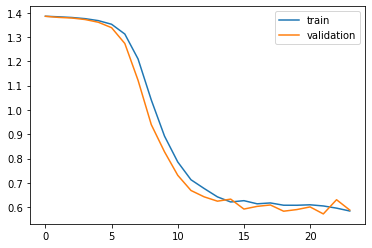

In [18]:
# Define the number of epochs and the patience for early stopping
num_epochs = 100
patience = 10

# Initialize the variables for tracking the best validation accuracy and the number of epochs since the best accuracy
best_val_acc = 0.0
epochs_since_best_val_acc = 0

train_curve=[]
val_curve=[]

# Train loop
for epoch in range(num_epochs):
    # Training
    model.train()
    tmp_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()# clear the gradients
        loss.backward()# gradient of the loss
        optimizer.step()# new weigths
        tmp_loss += loss.detach().numpy()
    train_curve.append(tmp_loss/len(train_loader))  
    # Validation
    model.eval()
    with torch.no_grad():
        val_acc = 0.0
        val_total = 0
        val_loss = 0
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            
            
            val_acc += accuracy(output, target)

        val_acc /=  len(val_loader)
        val_loss /= len(val_loader)
        val_curve.append(val_loss)

        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Check if the validation accuracy has improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_since_best_val_acc = 0
            best_weights = model.state_dict()
            torch.save(best_weights, 'results/best_weights.pth')
        else:
            epochs_since_best_val_acc += 1

        # Check if early stopping is necessary
        if epochs_since_best_val_acc >= patience:
            print("Early stopping!")
            break
plt.figure()
plt.plot(train_curve,label="train")
plt.plot(val_curve,label="validation")
plt.legend()

In [19]:
model=Net()
model.load_state_dict(torch.load('results/best_weights.pth'))
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)

In [20]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model, test_loader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            
            outputs = model(inputs)
            targets = targets.numpy()
            outputs = outputs.numpy()

            predicted = np.argmax(outputs, 1)
            targets = np.argmax(targets , 1)

            y_true.extend(targets)
            y_pred.extend(predicted)

    cm = confusion_matrix(y_true, y_pred,normalize="pred")

    return np.array(y_true), np.array(y_pred), cm

In [21]:
_,_,cm=test_model(model, test_loader)

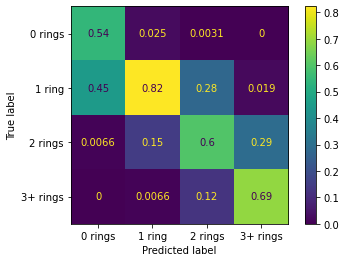

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["0 rings", "1 ring", "2 rings", "3+ rings"])
disp.plot()

plt.show()